# Image Classification with Transformers

## Introduction

In this notebook, we will use the `transformers` library to fine-tune a pre-trained transformer model for image classification. We will use the `ViT` model, which is a transformer model that was designed for image classification tasks. We will fine-tune the model on the `CIFAR-10` dataset, which is a dataset of 60,000 32x32 color images in 10 classes, with 6,000 images per class. The dataset is divided into 50,000 training images and 10,000 testing images.

`ViT` is a transformer model that was designed for image classification tasks. It works by dividing an image into patches, and then processing each patch with a transformer encoder. The model then uses a classification head to predict the class of the image. The model is pre-trained on the `ImageNet` dataset, which is a large dataset of natural images.

The architecture of the `ViT` model is as follows:

1. Input Embeddings: The input to the model is an image, which is divided into patches. Each patch is then linearly embedded to the same dimension as the model's hidden dimension. The formula for the number of patches are as follows:
2. Positional Embeddings: The model uses learnable positional embeddings to encode the position of each patch in the image.
3. Transformer Encoder: The model uses a transformer encoder to process the patches. The encoder consists of multiple layers which are:
    - Multi-Head Self-Attention: The model uses multi-head self-attention to capture the relationships between different patches in the image.
    - Feed-Forward Neural Network: The model uses a feed-forward neural network to process the output of the self-attention layer.
    - Residual Connection: The model uses residual connections around each sub-layer, followed by layer normalization.
4. Classification Head: The model uses a classification head to predict the class of the image.

The formula for different blocks are as follows:

1. Embedding Block: The embedding block consists of a linear layer to embed the patches, followed by a positional embedding layer.
    - `x = patch_embeddings(x) + position_embeddings`
    - `patch_embeddings`: Linear layer to embed the patches
      - $PE_{(patch, i)} = xW_{patch} + b_{patch}$
    - `position_embeddings`: Positional embeddings to encode the position of each patch
      - $PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})$

2. Transformer Encoder Block: The transformer encoder block consists of a multi-head self-attention layer, followed by a feed-forward neural network.
    - `self_attention`: Multi-head self-attention layer
      - $softmax(\frac{QK^T}{\sqrt{d_k}})V = Attention(Q, K, V)$
      - $concat(head_1, head_2, ..., head_n)W^O = MultiHead(Q, K, V)$
    - `feed_forward`: Feed-forward neural network
      - $FFN(x) = max(0, xW_1 + b_1)W_2 + b_2$
      - `W_1`, `b_1`: Weight and bias of the first linear layer
    - `LayerNorm(x)`: Layer normalization
      - $LayerNorm(x) = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}}$
    - `Residual(x, y)`: Residual connection
      - $Residual(x, y) = x + y$

[This paper](https://openaccess.thecvf.com/content/ICCV2023/papers/Xu_FDViT_Improve_the_Hierarchical_Architecture_of_Vision_Transformer_ICCV_2023_paper.pdf) proposes a novel hierarchical architecture for vision transformers called FDViT to address the challenge of high computational costs in vision transformers. The key ideas are:
1. Introducing a flexible downsampling (FD) layer that is not limited to integer stride, allowing for smooth reduction of spatial dimensions to avoid excessive information loss.
2. Using a masked auto-encoder architecture to facilitate the training of the FD layers and generate informative outputs.
The proposed FDViT achieves better classification performance with fewer FLOPs and parameters compared to existing hierarchical vision transformer models. Experiments on ImageNet, COCO, and ADE20K datasets demonstrate the effectiveness of the method.

Also [this paper](https://research.google/blog/improving-vision-transformer-efficiency-and-accuracy-by-learning-to-tokenize/) discusses a module called TokenLearner that can be used to improve the efficiency and accuracy of Vision Transformer (ViT) models. TokenLearner is a learnable module that generates a smaller set of adaptive tokens from the input image or video, rather than using a fixed, uniform tokenization. This reduces the number of tokens that need to be processed by the subsequent Transformer layers, leading to significant savings in memory and computation without compromising performance. The document presents experiments showing that inserting TokenLearner at different locations within a ViT model can achieve comparable or better accuracy than the baseline ViT, while reducing the computational cost by up to two-thirds. TokenLearner is particularly effective for video understanding tasks, where it achieves state-of-the-art performance on several benchmarks.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay

import torchvision
from torchvision import datasets, models
from torchvision.models import vision_transformer
from torchvision import transforms as torchvision_transforms

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation
from keras.models import Sequential, Model, load_model, save_model, model_from_json
from keras.applications import VGG19, ResNet152V2, DenseNet201, EfficientNetV2L
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import OneHotEncoder
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, Callback
from keras import backend as K
from keras.metrics import categorical_crossentropy
from keras.datasets import cifar10
from keras.utils import to_categorical

from transformers import DeiTModel, DeiTConfig, DeiTForImageClassification, DeiTFeatureExtractor, AutoFeatureExtractor, AutoModel, AutoConfig, AutoTokenizer, AutoModelForImageClassification, ViTFeatureExtractor, ViTModel, ViTForImageClassification
from pytorch_pretrained_vit import ViT, load_pretrained_weights
import timm

import cv2
import PIL as Image

import random
import tqdm
import os
import time
from tabulate import tabulate

## Fine-Tuning CNN

we want to use transfer learning on both CNN and Transformers. we call our fine-tuning restrictive because we only unfreeze the last block of the models to identify which model architecture has the best raw transfer learning capabilities.

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_val, y_val = x_train[40000:], y_train[40000:]
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)
y_val_onehot = to_categorical(y_val)

In [3]:
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(x_train)

In [4]:
cifar10_labels = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]
cifar10_input_shape = (32, 32, 3)

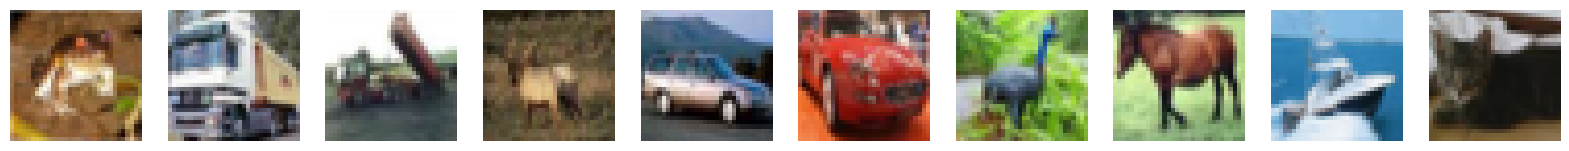

In [5]:
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    axes[i].imshow(x_train[i])
    axes[i].axis("off")
plt.show()

In [6]:
x_train = x_train / 255
x_test = x_test / 255

In [7]:
def plot_metrics(history: keras.callbacks.History):

    fig, axs = plt.subplots(2, 1, figsize=(8, 8))

    axs[0].plot(history.history["loss"], label="Training Loss")
    axs[0].plot(history.history["val_loss"], label="Validation Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(history.history["accuracy"], label="Training Accuracy")
    axs[1].plot(history.history["val_accuracy"], label="Validation Accuracy")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [8]:
def layer_specific_summary(model: keras.Model):
    for i, layer in enumerate(model.layers):
        print(i, layer.name, layer.trainable)

In [9]:
def save_model(model: keras.Model, model_name: str):
    model_json = model.to_json()
    with open(f"../models/{model_name}.json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights(f"{model_name}.h5")
    print("Saved model to disk")

In [10]:
def load_model(model_name: str) -> keras.Model:
    json_file = open(f"../models/{model_name}.json", "r")
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(f"{model_name}.h5")
    print("Loaded model from disk")
    return loaded_model

In [11]:
def scheduler(epoch: int, lr: float) -> float:
    # The learning rate reduces by a factor of 0.6 and has a minimum value of 0.0000001.
    return max(0.0000001, lr * 0.6)

LR_sched = LearningRateScheduler(scheduler)  

In [12]:
class EpochTimeCallback(Callback):
    def __init__(self):
        super(EpochTimeCallback, self).__init__()
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        duration = time.time() - self.epoch_start
        self.epoch_times.append(duration)
        print(f"\nEpoch {epoch+1} took {duration:.2f} seconds\n")
        
    def on_train_begin(self, logs=None):
        self.epoch_times = []
    
    def on_train_end(self, logs=None):
        print(f"\nAverage epoch time: {np.mean(self.epoch_times):.2f} seconds\n")
        
    def on_test_begin(self, logs=None):
        self.test_start = time.time()
        
    def on_test_end(self, logs=None):
        duration = time.time() - self.test_start
        print(f"\nTesting took {duration:.2f} seconds\n")
        
    def get_average_epoch_time(self):
        return np.mean(self.epoch_times)

In [13]:
def analyze_model(model: keras.Model, history: keras.callbacks.History, time_callback: EpochTimeCallback, x_test: np.ndarray, y_test: np.ndarray):
    print("\n\n")
    print(tabulate([
        ["Training Loss", history.history["loss"][-1]],
        ["Validation Loss", history.history["val_loss"][-1]],
        ["Training Accuracy", history.history["accuracy"][-1]],
        ["Validation Accuracy", history.history["val_accuracy"][-1]],
    ]))
    print("\n\n")
    plot_metrics(history)
    time_callback.on_test_begin()
    model.evaluate(x_test, y_test)
    time_callback.on_test_end()
    print(time_callback.get_average_epoch_time())
    print("\n\n")
    print(classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(x_test), axis=1), target_names=cifar10_labels))
    print("\n\n")
    

In [14]:
def froze_CNN_layers(cnn_base: keras.Model, starting_layer_name: str):
    cnn_base.trainable = True
    
    trainable = False
    
    for layer in cnn_base.layers:
        if layer.name == starting_layer_name:
            trainable = True
            
        layer.trainable = trainable

In [15]:
def create_VGG19_model(input_shape: tuple, num_classes: int) -> tuple[keras.Model, keras.Model]:
    cnn_base = VGG19(weights="imagenet", include_top=False, input_shape=input_shape)
    model = Sequential()
    model.add(cnn_base)
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))
    
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return cnn_base, model

In [16]:
def create_VGG19_callbacks(model_name: str) -> list[keras.callbacks.Callback]:
    checkpoint = ModelCheckpoint(f"../models/{model_name}.h5", monitor="val_accuracy", save_best_only=True)
    early_stopping = EarlyStopping(monitor="val_accuracy", patience=5)
    epoch_time_callback = EpochTimeCallback()
    return [checkpoint, early_stopping, LR_sched, epoch_time_callback]

In [17]:
cnn_base_vgg19, vgg_19 = create_VGG19_model(cifar10_input_shape, len(cifar10_labels))

In [18]:
cnn_base_vgg19.trainable = False
vgg_19.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2

In [19]:
froze_CNN_layers(cnn_base_vgg19, "block5_conv1")
vgg_19.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2

In [20]:
vgg19_callbacks = create_VGG19_callbacks("vgg19")

In [21]:
vgg19_history = vgg_19.fit(
    datagen.flow(x_train, y_train_onehot, batch_size=512),
    batch_size=512,
    epochs=20,
    validation_data=(x_val, y_val_onehot),
    callbacks=vgg19_callbacks,
)

Epoch 1/20
98/98 [==============================] - ETA: 0s - loss: 1.8834 - accuracy: 0.3250
Testing took 2.34 seconds


Epoch 1 took 34.01 seconds

98/98 [==============================] - 34s 261ms/step - loss: 1.8834 - accuracy: 0.3250 - val_loss: 34.4285 - val_accuracy: 0.5291 - lr: 6.0000e-05
Epoch 2/20
98/98 [==============================] - ETA: 0s - loss: 1.2091 - accuracy: 0.6029
Testing took 1.10 seconds


Epoch 2 took 20.46 seconds

98/98 [==============================] - 20s 208ms/step - loss: 1.2091 - accuracy: 0.6029 - val_loss: 37.3958 - val_accuracy: 0.6428 - lr: 3.6000e-05
Epoch 3/20
98/98 [==============================] - ETA: 0s - loss: 0.9963 - accuracy: 0.6860
Testing took 1.09 seconds


Epoch 3 took 20.07 seconds

98/98 [==============================] - 20s 203ms/step - loss: 0.9963 - accuracy: 0.6860 - val_loss: 49.0069 - val_accuracy: 0.6341 - lr: 2.1600e-05
Epoch 4/20
98/98 [==============================] - ETA: 0s - loss: 0.9152 - accuracy: 0.7112
Testin




-------------------  ---------
Training Loss         0.798546
Validation Loss      52.2866
Training Accuracy     0.74702
Validation Accuracy   0.6483
-------------------  ---------





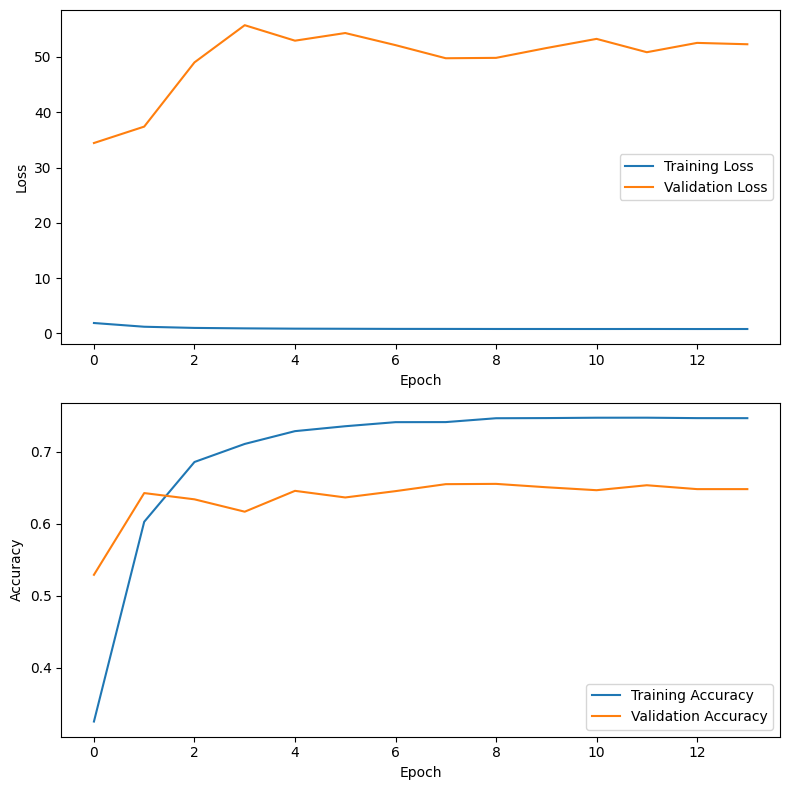

313/313 [==============================] - 4s 12ms/step - loss: 0.6897 - accuracy: 0.7749

Testing took 4.34 seconds

21.611588750566757



313/313 [==============================] - 3s 9ms/step
              precision    recall  f1-score   support

    airplane       0.78      0.86      0.82      1000
  automobile       0.82      0.93      0.87      1000
        bird       0.76      0.65      0.70      1000
         cat       0.67      0.52      0.59      1000
        deer       0.76      0.70      0.73      1000
         dog       0.76      0.63      0.69      1000
        frog       0.71      0.90      0.79      1000
       horse       0.75      0.86      0.80      1000
        ship       0.91      0.83      0.87      1000
       truck       0.83      0.87      0.85      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000






In [22]:
analyze_model(vgg_19, vgg19_history, vgg19_callbacks[-1], x_test, y_test_onehot)

In [30]:
def create_DenseNet201_model(input_shape: tuple, num_classes: int) -> tuple[keras.Model, keras.Model]:
    cnn_base = DenseNet201(weights="imagenet", include_top=False, input_shape=input_shape)
    model = Sequential()
    model.add(cnn_base)
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))
    
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return cnn_base, model

In [31]:
def create_DenseNet201_callbacks(model_name: str) -> list[keras.callbacks.Callback]:
    checkpoint = ModelCheckpoint(f"../models/{model_name}.h5", monitor="val_accuracy", save_best_only=True)
    early_stopping = EarlyStopping(monitor="val_accuracy", patience=5)
    epoch_time_callback = EpochTimeCallback()
    return [checkpoint, early_stopping, LR_sched, epoch_time_callback]

In [32]:
cnn_base_densenet201, densenet201 = create_DenseNet201_model(cifar10_input_shape, len(cifar10_labels))

In [33]:
cnn_base_densenet201.trainable = False
densenet201.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1, 1, 1920)        18321984  
                                                                 
 flatten_2 (Flatten)         (None, 1920)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               491776    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 10)               

In [34]:
froze_CNN_layers(cnn_base_densenet201, "conv5_block1_0_bn")
densenet201.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1, 1, 1920)        18321984  
                                                                 
 flatten_2 (Flatten)         (None, 1920)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               491776    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 10)               

In [35]:
densenet201_callbacks = create_DenseNet201_callbacks("densenet201")

In [36]:
densenet201_history = densenet201.fit(
    datagen.flow(x_train, y_train_onehot, batch_size=512),
    epochs=20,
    validation_data=(x_val, y_val_onehot),
    callbacks=densenet201_callbacks,
)

Epoch 1/20
98/98 [==============================] - ETA: 0s - loss: 2.2423 - accuracy: 0.1854
Testing took 9.59 seconds


Epoch 1 took 50.28 seconds

98/98 [==============================] - 50s 369ms/step - loss: 2.2423 - accuracy: 0.1854 - val_loss: 8.1071 - val_accuracy: 0.1168 - lr: 6.0000e-05
Epoch 2/20
98/98 [==============================] - ETA: 0s - loss: 1.6915 - accuracy: 0.3990
Testing took 7.37 seconds


Epoch 2 took 34.18 seconds

98/98 [==============================] - 34s 348ms/step - loss: 1.6915 - accuracy: 0.3990 - val_loss: 69.4222 - val_accuracy: 0.1169 - lr: 3.6000e-05
Epoch 3/20
98/98 [==============================] - ETA: 0s - loss: 1.3366 - accuracy: 0.5411
Testing took 7.48 seconds


Epoch 3 took 32.77 seconds

98/98 [==============================] - 33s 332ms/step - loss: 1.3366 - accuracy: 0.5411 - val_loss: 228.9320 - val_accuracy: 0.1017 - lr: 2.1600e-05
Epoch 4/20
98/98 [==============================] - ETA: 0s - loss: 1.1804 - accuracy: 0.6026
Testin




-------------------  ---------
Training Loss          1.04151
Validation Loss      494.621
Training Accuracy      0.6591
Validation Accuracy    0.1015
-------------------  ---------





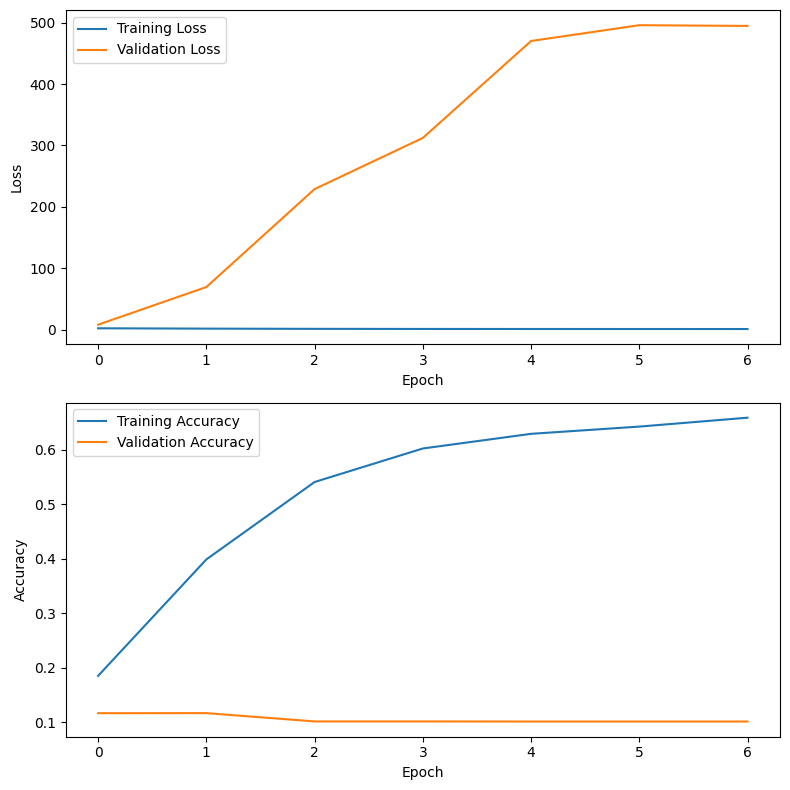

313/313 [==============================] - 12s 29ms/step - loss: 0.8915 - accuracy: 0.6998

Testing took 11.95 seconds

37.463414260319304



313/313 [==============================] - 12s 30ms/step
              precision    recall  f1-score   support

    airplane       0.74      0.78      0.76      1000
  automobile       0.79      0.90      0.84      1000
        bird       0.62      0.60      0.61      1000
         cat       0.55      0.34      0.42      1000
        deer       0.70      0.54      0.61      1000
         dog       0.71      0.54      0.61      1000
        frog       0.54      0.89      0.67      1000
       horse       0.70      0.80      0.75      1000
        ship       0.85      0.82      0.84      1000
       truck       0.83      0.79      0.81      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.69     10000
weighted avg       0.70      0.70      0.69     10000






In [37]:
analyze_model(densenet201, densenet201_history, densenet201_callbacks[-1], x_test, y_test_onehot)